# Data Load

In [1]:
import os
import glob
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, countDistinct, sum, when, count, lit, to_date, concat, collect_list, expr, udf, row_number, size, sqrt, avg, ntile, round as spark_round
from pyspark.ml.recommendation import ALS
from pyspark.ml.linalg import DenseVector, VectorUDT, Vectors
from pyspark.ml.feature import HashingTF, IDF, StringIndexer
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
from pyspark.ml.functions import vector_to_array

In [2]:
# Load JAVA
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

# Start Spark session (local mode)
spark = SparkSession.builder \
    .appName("LoadParquetSpark") \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()

# Reduce log output to only errors
spark.sparkContext.setLogLevel("ERROR")

# Load dataset
main_folder = os.path.dirname(os.getcwd())

filtered_df_folder = os.path.join(main_folder, "2. data_processing", "db", "filtered")
filtered_df_files = glob.glob(os.path.join(filtered_df_folder, "*.parquet"))

if filtered_df_files:
    latest_file = max(filtered_df_files, key=os.path.getctime)
    df = spark.read.parquet(latest_file)
else:
    print("No parquet files found in the filtered folder.")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/19 18:56:26 WARN Utils: Your hostname, Orinash, resolves to a loopback address: 127.0.1.1; using 192.168.15.143 instead (on interface wlo1)
25/06/19 18:56:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/19 18:56:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df.printSchema()

root
 |-- user_steamid: string (nullable = true)
 |-- user_personaname: string (nullable = true)
 |-- user_loccountrycode: string (nullable = true)
 |-- game_appid: long (nullable = true)
 |-- game_name: string (nullable = true)
 |-- game_playtime_forever: double (nullable = true)
 |-- game_detail_release_date: string (nullable = true)
 |-- game_detail_developer: string (nullable = true)
 |-- game_detail_publisher: string (nullable = true)
 |-- game_detail_genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- game_detail_tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- game_detail_rating: string (nullable = true)



In [4]:
def df_info (df):
    # Unique counts
    unique_counts = df.select(
        *[countDistinct(col(c)).alias(c) for c in df.columns]
    ).withColumn("metric", lit("unique"))

    # Null counts
    null_counts = df.select(
        *[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]
    ).withColumn("metric", lit("nulls"))

    # Filled counts
    filled_counts = df.select(
        *[count(col(c)).alias(c) for c in df.columns]
    ).withColumn("metric", lit("filled"))

    # Union all three DataFrames
    summary = unique_counts.unionByName(null_counts).unionByName(filled_counts)

    # Transpose: from wide to long format
    transposed = summary.selectExpr(
        "stack({0}, {1}) as (column_name, value)".format(
            len(df.columns),
            ", ".join([f"'{c}', `{c}`" for c in df.columns])
        ),
        "metric"
    ).groupBy("column_name").pivot("metric").agg({"value": "first"})

    # Show final transposed summary
    return transposed.show(truncate=False)


In [5]:
df_info(df)

+------------------------+-------+------+------+
|column_name             |filled |nulls |unique|
+------------------------+-------+------+------+
|game_appid              |3250386|0     |41485 |
|user_personaname        |3250386|0     |232754|
|user_loccountrycode     |2625264|625122|251   |
|game_detail_release_date|2829722|420664|5674  |
|game_playtime_forever   |3004809|245577|50266 |
|game_detail_genres      |2829722|420664|1498  |
|game_detail_tags        |2829722|420664|34107 |
|game_detail_rating      |2826010|424376|18    |
|user_steamid            |3250386|0     |259855|
|game_detail_developer   |2820912|429474|21454 |
|game_name               |3004809|245577|41372 |
|game_detail_publisher   |2804114|446272|16194 |
+------------------------+-------+------+------+



In [6]:
df.show(5)

+-----------------+----------------+-------------------+----------+---------+---------------------+------------------------+---------------------+---------------------+------------------+----------------+------------------+
|     user_steamid|user_personaname|user_loccountrycode|game_appid|game_name|game_playtime_forever|game_detail_release_date|game_detail_developer|game_detail_publisher|game_detail_genres|game_detail_tags|game_detail_rating|
+-----------------+----------------+-------------------+----------+---------+---------------------+------------------------+---------------------+---------------------+------------------+----------------+------------------+
|76561198072538644|Demonow thy Wife|               NULL|         0|     NULL|                 NULL|                    NULL|                 NULL|                 NULL|              NULL|            NULL|              NULL|
|76561198204235171|    ☂ㅤㅤᴠɪɴɪ么☯|                 BR|         0|     NULL|                 NULL|        

# Data Preprocessing

## Removing nulls on genre and tags

In [7]:
df_drop_nulls = df.na.drop(subset=['game_detail_tags', 'game_detail_rating'])

In [8]:
df_info(df_drop_nulls)

+------------------------+-------+------+------+
|column_name             |filled |nulls |unique|
+------------------------+-------+------+------+
|game_appid              |2826010|0     |38738 |
|user_personaname        |2826010|0     |14028 |
|user_loccountrycode     |2318356|507654|190   |
|game_detail_release_date|2826010|0     |5629  |
|game_playtime_forever   |2826010|0     |49925 |
|game_detail_genres      |2826010|0     |1494  |
|game_detail_tags        |2826010|0     |33854 |
|game_detail_rating      |2826010|0     |18    |
|user_steamid            |2826010|0     |14276 |
|game_detail_developer   |2817264|8746  |21255 |
|game_name               |2826010|0     |38673 |
|game_detail_publisher   |2800432|25578 |16031 |
+------------------------+-------+------+------+



## Removing game_playtime_forever zeros

In [9]:
df_drop_zeros = df_drop_nulls.filter(col('game_playtime_forever') > 0)

In [10]:
df_info(df_drop_zeros)

+------------------------+-------+------+------+
|column_name             |filled |nulls |unique|
+------------------------+-------+------+------+
|game_appid              |1579134|0     |27555 |
|user_personaname        |1579134|0     |12664 |
|user_loccountrycode     |1295625|283509|188   |
|game_detail_release_date|1579134|0     |5314  |
|game_playtime_forever   |1579134|0     |49924 |
|game_detail_genres      |1579134|0     |1366  |
|game_detail_tags        |1579134|0     |26022 |
|game_detail_rating      |1579134|0     |18    |
|user_steamid            |1579134|0     |12870 |
|game_detail_developer   |1575866|3268  |16168 |
|game_name               |1579134|0     |27523 |
|game_detail_publisher   |1566088|13046 |11952 |
+------------------------+-------+------+------+



# Data Exploration

## Playtime

### With zeros

In [11]:
# Number of players
players = df_drop_nulls.select('user_steamid').distinct().count()

# Number of games
games = df_drop_nulls.select('game_appid').distinct().count()

# Average playtime per user
avg_playtime_per_user = df_drop_nulls.groupBy('user_steamid').agg(avg('game_playtime_forever').alias('avg_playtime'))
overall_avg_playtime_per_user = avg_playtime_per_user.agg(avg('avg_playtime')).collect()[0]['avg(avg_playtime)']


# Average playtime per game
avg_playtime_per_game = df_drop_nulls.groupBy('game_appid').agg(avg('game_playtime_forever').alias('avg_playtime'))
overall_avg_playtime_per_game = avg_playtime_per_game.agg(avg('avg_playtime')).collect()[0]['avg(avg_playtime)']

# Show results
print(f"Number of players: {players}")
print(f"Number of games: {games}")
print(f"Average playtime per player (in hours): {round(overall_avg_playtime_per_user / 60, 2)}")
print(f"Average playtime per game (in hours): {round(overall_avg_playtime_per_game/60, 2)}")


Number of players: 14276
Number of games: 38738
Average playtime per player (in hours): 97.65
Average playtime per game (in hours): 6.44


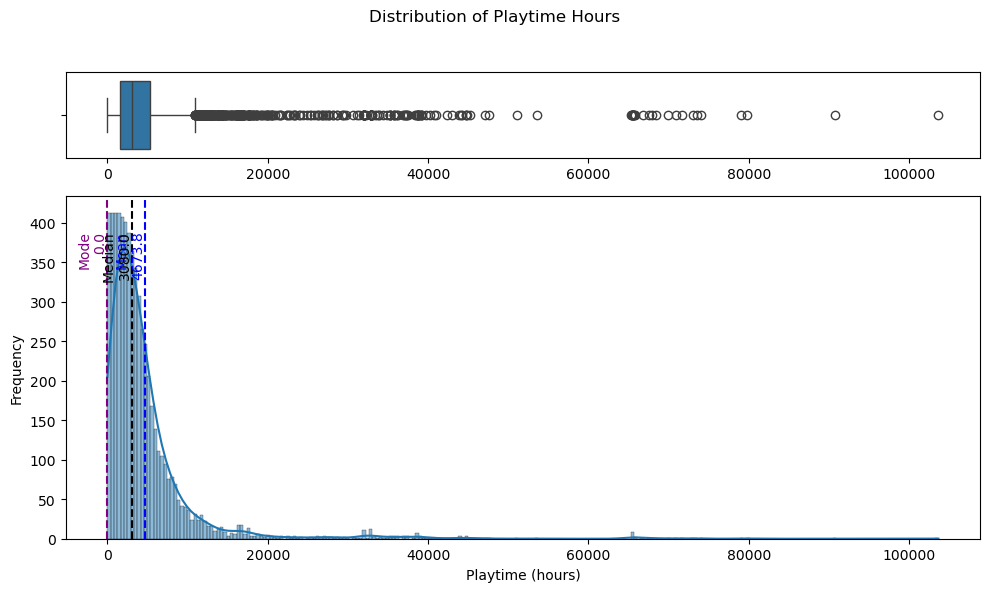

In [12]:
# Filter data
viz_playtime = df_drop_nulls.withColumn('playtime_hours', spark_round(col('game_playtime_forever') / 60))
viz_playtime = viz_playtime.select('playtime_hours')
viz_playtime = viz_playtime.groupBy('playtime_hours').count()
viz_playtime = viz_playtime.toPandas()

# Calculate statistics
mean_val = viz_playtime['playtime_hours'].mean()
q1 = viz_playtime['playtime_hours'].quantile(0.25)
q2 = viz_playtime['playtime_hours'].quantile(0.50)
q3 = viz_playtime['playtime_hours'].quantile(0.75)
mode_val = viz_playtime.loc[viz_playtime['count'].idxmax(), 'playtime_hours']

# Fig configuration
fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 4]})

# Box Plot
sns.boxplot(x=viz_playtime['playtime_hours'], ax=ax[0], orient='h')
ax[0].set_xlabel('')

# Histogram
sns.histplot(viz_playtime['playtime_hours'], ax=ax[1], kde=True)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Playtime (hours)')

# Add statistics
stats = [
    (mean_val, 'Mean', 'blue'),
    #(q1, 'Q1', 'orange'),
    (q2, 'Median', 'black'),
    #(q3, 'Q3', 'red'),
    (mode_val, 'Mode', 'purple')
]

for val, label, color in stats:
    ax[1].axvline(val, color=color, linestyle='--', linewidth=1.5, label=f'{label}: {val:.2f}')
    ax[1].text(val, ax[1].get_ylim()[1]*0.9, f'{label}\n{val:.1f}', color=color, rotation=90, ha='right', va='top')

# Title
plt.suptitle('Distribution of Playtime Hours')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


### Without zeros

In [13]:
# Number of users
players = df_drop_zeros.select('user_steamid').distinct().count()

# Number of games
games = df_drop_zeros.select('game_appid').distinct().count()

# Average playtime per user
avg_playtime_per_user = df_drop_zeros.groupBy('user_steamid').agg(avg('game_playtime_forever').alias('avg_playtime'))
overall_avg_playtime_per_user = avg_playtime_per_user.agg(avg('avg_playtime')).collect()[0]['avg(avg_playtime)']


# Average playtime per game
avg_playtime_per_game = df_drop_zeros.groupBy('game_appid').agg(avg('game_playtime_forever').alias('avg_playtime'))
overall_avg_playtime_per_game = avg_playtime_per_game.agg(avg('avg_playtime')).collect()[0]['avg(avg_playtime)']

# Show results
print(f"Number of players: {players}")
print(f"Number of games: {games}")
print(f"Average playtime per player (in hours): {round(overall_avg_playtime_per_user/60,2)}")
print(f"Average playtime per game (in hours): {round(overall_avg_playtime_per_game/60,2)}")

Number of players: 12870
Number of games: 27555
Average playtime per player (in hours): 150.49
Average playtime per game (in hours): 15.16


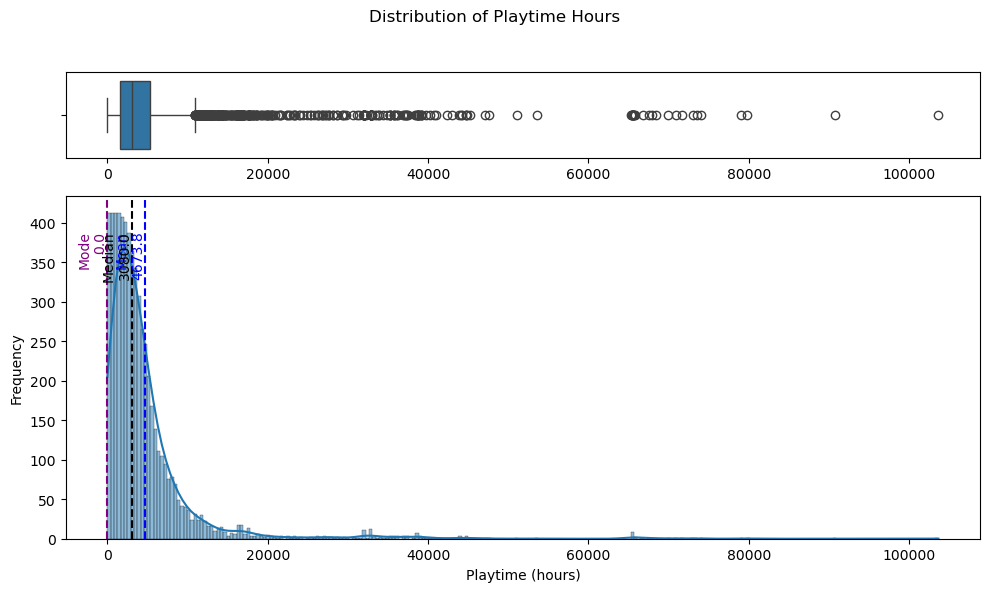

In [14]:
# Filter data
viz_playtime = df_drop_zeros.withColumn('playtime_hours', spark_round(col('game_playtime_forever') / 60))
viz_playtime = viz_playtime.select('playtime_hours')
viz_playtime = viz_playtime.groupBy('playtime_hours').count()
viz_playtime = viz_playtime.toPandas()

# Calculate statistics
mean_val = viz_playtime['playtime_hours'].mean()
q1 = viz_playtime['playtime_hours'].quantile(0.25)
q2 = viz_playtime['playtime_hours'].quantile(0.50)
q3 = viz_playtime['playtime_hours'].quantile(0.75)
mode_val = viz_playtime.loc[viz_playtime['count'].idxmax(), 'playtime_hours']

# Fig configuration
fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 4]})

# Box Plot
sns.boxplot(x=viz_playtime['playtime_hours'], ax=ax[0], orient='h')
ax[0].set_xlabel('')

# Histogram
sns.histplot(viz_playtime['playtime_hours'], ax=ax[1], kde=True)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Playtime (hours)')

# Add statistics
stats = [
    (mean_val, 'Mean', 'blue'),
    #(q1, 'Q1', 'orange'),
    (q2, 'Median', 'black'),
    #(q3, 'Q3', 'red'),
    (mode_val, 'Mode', 'purple')
]

for val, label, color in stats:
    ax[1].axvline(val, color=color, linestyle='--', linewidth=1.5, label=f'{label}: {val:.2f}')
    ax[1].text(val, ax[1].get_ylim()[1]*0.9, f'{label}\n{val:.1f}', color=color, rotation=90, ha='right', va='top')

# Title
plt.suptitle('Distribution of Playtime Hours')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Playtime by game

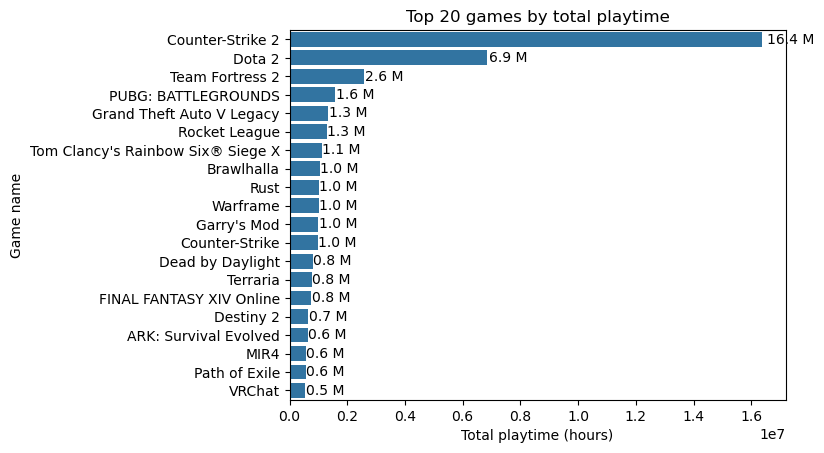

In [15]:
# Playtime by game
playtime_by_game = df_drop_zeros.groupBy('game_name').agg(spark_round(sum(col('game_playtime_forever')) / 60).alias('total_playtime')).orderBy('total_playtime', ascending=False)
playtime_by_game = playtime_by_game.toPandas()

# Bar chart
sns.barplot(x='total_playtime', y='game_name', data=playtime_by_game.head(20))
plt.title('Top 20 games by total playtime')
plt.xlabel('Total playtime (hours)')
plt.ylabel('Game name')

# Get current Axes
ax = plt.gca()

# Add text labels formatted as millions
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    label = f'{width / 1_000_000:.1f} M'  
    ax.text(width + (width * 0.01), y, label, va='center')

plt.show()



### Players by game

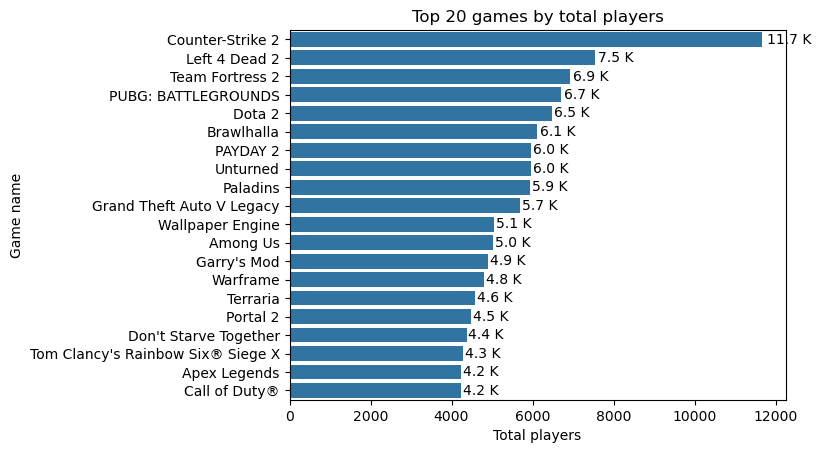

In [16]:
# Playtime by game
players_by_game = df_drop_zeros.groupBy('game_name').agg(spark_round(count(col('user_steamid'))).alias('total_players')).orderBy('total_players', ascending=False)
players_by_game = players_by_game.toPandas()

# Bar chart
sns.barplot(x='total_players', y='game_name', data=players_by_game.head(20))
plt.title('Top 20 games by total players')
plt.xlabel('Total players')
plt.ylabel('Game name')

# Get current Axes
ax = plt.gca()

# Add text labels formatted as millions
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    label = f'{width / 1_000:.1f} K'  
    ax.text(width + (width * 0.01), y, label, va='center')

plt.show()

### Bayesian Playtime

With the bayesian playtime, if some users only played a few games, their average playtime might be unreliable. This formula helps by pulling their average towards the global mean, depending on how much data (number of games) they have.

$$
q = \frac{\sum_{i=1}^{n} r_i + C \times m}{C + n}
$$

Where:

- $r$ is the playtime of each game
- $n$ is the total number of observed values ofr the item
- $C$ is the average number of players across all games
- $m$ is the overall average playtime in the whole set

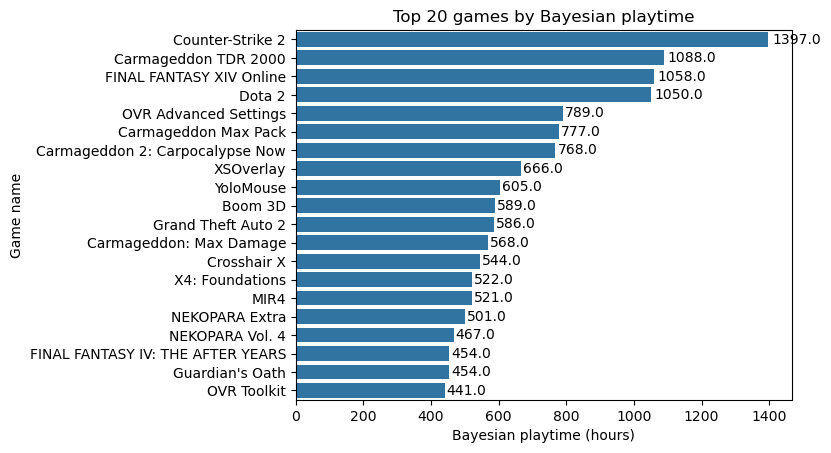

In [17]:
df_bayesian_playtime = df_drop_zeros.groupBy('game_appid').agg(
    sum('game_playtime_forever').alias('total_playtime'), #r
    count('user_steamid').alias('num_players')
)

C = df_bayesian_playtime.agg(avg('num_players')).collect()[0][0]
m = df_drop_zeros.agg(avg('game_playtime_forever')).collect()[0][0]

df_game_names = df_drop_zeros.select("game_appid", "game_name").dropDuplicates(["game_appid"])

df_bayesian_playtime = df_bayesian_playtime.withColumn('bayesian_playtime', (df_bayesian_playtime.total_playtime + C * m) / (C + df_bayesian_playtime.num_players))
df_bayesian_playtime = df_bayesian_playtime.join(df_game_names, on='game_appid', how='left').select('game_appid', 'game_name', 'total_playtime', 'num_players', 'bayesian_playtime')
df_bayesian_playtime = df_bayesian_playtime.groupBy('game_name').agg(spark_round(sum(col('bayesian_playtime')) / 60).alias('total_bayesian_playtime')).orderBy('total_bayesian_playtime', ascending=False)

df_bayesian_playtime = df_bayesian_playtime.toPandas()

# Bar chart
sns.barplot(x='total_bayesian_playtime', y='game_name', data=df_bayesian_playtime.head(20))
plt.title('Top 20 games by Bayesian playtime')
plt.xlabel('Bayesian playtime (hours)')
plt.ylabel('Game name')

# Get current Axes
ax = plt.gca()

# Add text labels formatted as millions
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    label = f'{width}'
    ax.text(width + (width * 0.01), y, label, va='center')

plt.show()

## Defining a ranking for games and comparing

Assigning a rating from 1 to 5 to each row based on how much a user has played each game, where:

- 5 = most played game(s) per user
- 1 = least played game(s) per user

In [18]:
window_spec = Window.partitionBy('user_steamid').orderBy(col('game_playtime_forever').desc())
df_rating = df_drop_zeros.withColumn("raw_tile", ntile(5).over(window_spec))
df_rating = df_rating.withColumn("rating", expr("6 - raw_tile"))

### Analysing data based on ranking

#### Rating Distribution

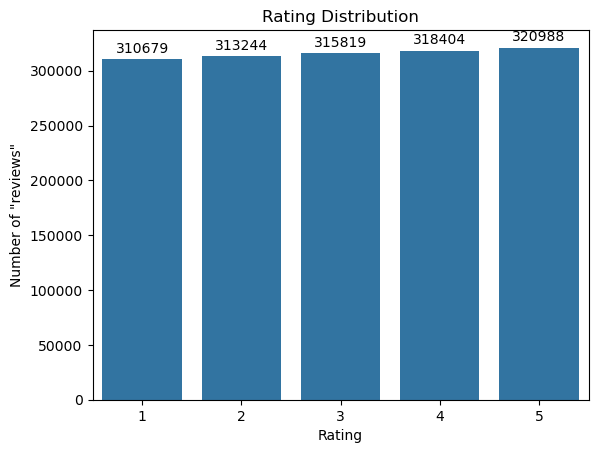

In [19]:
# Filter data
viz_rating = df_rating.groupBy('rating').count()
viz_rating = viz_rating.toPandas()

sns.barplot(x='rating', y='count', data=viz_rating)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of "reviews"')

# Annotate bars with values
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    label = f'{height:.0f}'
    ax.text(x, height + (height * 0.01), label, ha='center', va='bottom', fontsize=10)

plt.show()

#### Top Games by Average Rating

/home/eliascid/anaconda3/envs/recommendation_system/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12298 (\N{LEFT DOUBLE ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/eliascid/anaconda3/envs/recommendation_system/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 34560 (\N{CJK UNIFIED IDEOGRAPH-8700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/eliascid/anaconda3/envs/recommendation_system/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/eliascid/anaconda3/envs/recommendation_system/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/eliascid/anaconda3

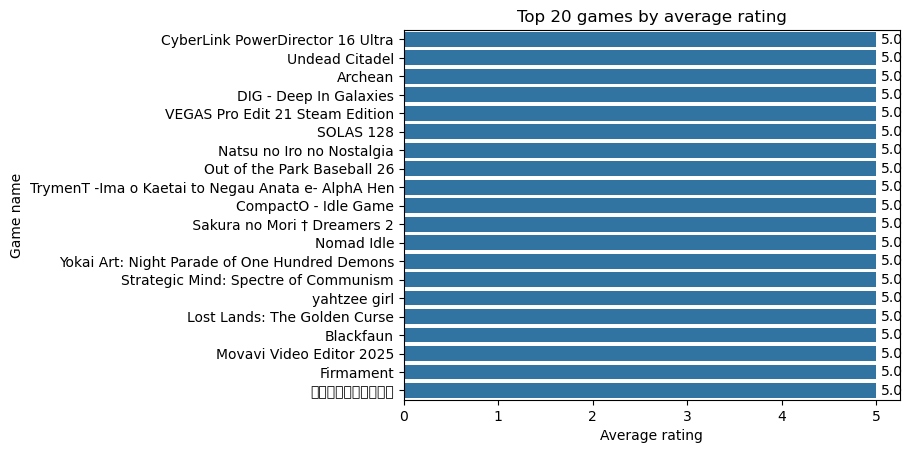

In [20]:
df_game_names = df_rating.select("game_appid", "game_name").dropDuplicates(["game_appid"])

average_rating = df_rating.groupBy('game_appid').agg(
    avg('rating').alias('average_rating'),
    count('user_steamid').alias('num_players')
)
average_rating = average_rating.join(df_game_names, on='game_appid', how='left')\
                               .select('game_name', 'average_rating', 'num_players')\
                               .orderBy('average_rating', ascending=False)

average_rating = average_rating.toPandas()

# Bar chart
sns.barplot(x='average_rating', y='game_name', data=average_rating.head(20))
plt.title('Top 20 games by average rating')
plt.xlabel('Average rating')
plt.ylabel('Game name')

# Get current Axes
ax = plt.gca()

# Add text labels formatted as millions
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    label = f'{width}'
    ax.text(width + (width * 0.01), y, label, va='center')

plt.show()

#### Top Games by Bayesian Average Rating

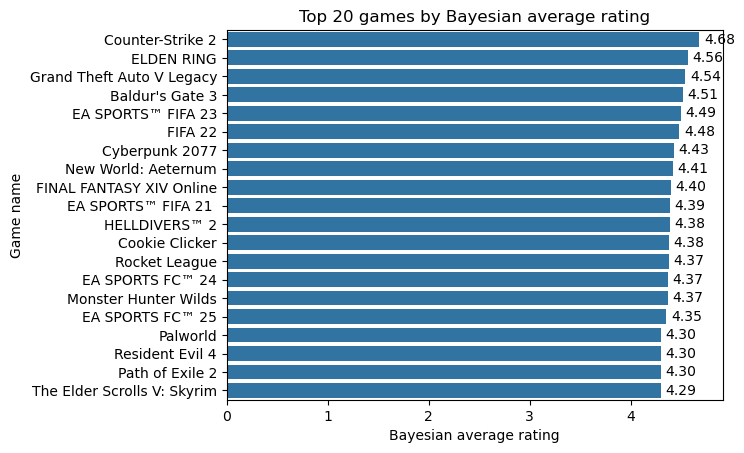

In [21]:
df_game_names = df_rating.select("game_appid", "game_name").dropDuplicates(["game_appid"])

bayesian_average_rating = df_rating.groupBy('game_appid').agg(
    sum('rating').alias('total_rating'),
    avg('rating').alias('avg_rating'),
    count('user_steamid').alias('num_players')
)

C = bayesian_average_rating.agg(avg('num_players')).collect()[0][0]
m = df_rating.agg(avg('rating')).collect()[0][0]

bayesian_average_rating = bayesian_average_rating.withColumn('bayesian_rating', (bayesian_average_rating.total_rating + C * m) / (C + bayesian_average_rating.num_players))
bayesian_average_rating = bayesian_average_rating.join(df_game_names, on='game_appid', how='left')\
                                                 .select('game_appid', 'game_name', 'avg_rating', 'num_players', 'bayesian_rating')
bayesian_average_rating = bayesian_average_rating.select('game_name', 'bayesian_rating')\
                                                 .orderBy('bayesian_rating', ascending=False)
bayesian_average_rating = bayesian_average_rating.toPandas()

# Bar chart
sns.barplot(x='bayesian_rating', y='game_name', data=bayesian_average_rating.head(20))
plt.title('Top 20 games by Bayesian average rating')
plt.xlabel('Bayesian average rating')
plt.ylabel('Game name')

# Get current Axes
ax = plt.gca()

# Add text labels formatted as millions
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    label = f'{width:.2f}'
    ax.text(width + (width * 0.01), y, label, va='center')

plt.show()


## Genre and tags

### Exploding genre and tags

In [22]:
# Filter unique games
df_game_genres = df_drop_zeros.select('game_appid', 'game_detail_genres').dropDuplicates()
df_game_tags = df_drop_zeros.select('game_appid', 'game_detail_tags').dropDuplicates()

In [23]:
# Explode genre and tags
df_exploded_genres = df_game_genres.withColumn("game_detail_genres", explode("game_detail_genres"))
df_exploded_tags = df_game_tags.withColumn("game_detail_tags", explode("game_detail_tags"))

In [24]:
df_exploded_genres.printSchema()
df_exploded_tags.printSchema()

root
 |-- game_appid: long (nullable = true)
 |-- game_detail_genres: string (nullable = true)

root
 |-- game_appid: long (nullable = true)
 |-- game_detail_tags: string (nullable = true)



In [25]:
df_info(df_exploded_genres)
df_info(df_exploded_tags)

+------------------+------+-----+------+
|column_name       |filled|nulls|unique|
+------------------+------+-----+------+
|game_appid        |76851 |0    |27555 |
|game_detail_genres|76851 |0    |24    |
+------------------+------+-----+------+



+----------------+------+-----+------+
|column_name     |filled|nulls|unique|
+----------------+------+-----+------+
|game_appid      |399964|0    |27555 |
|game_detail_tags|399964|0    |446   |
+----------------+------+-----+------+



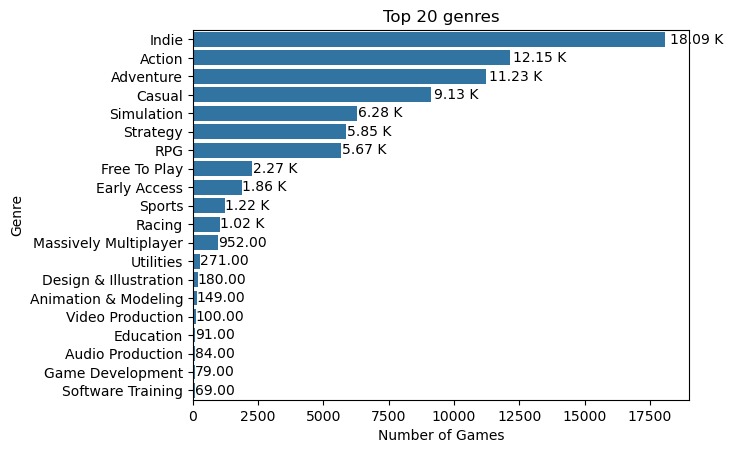

In [26]:
viz_genres = df_exploded_genres.groupBy('game_detail_genres').count()
viz_genres = viz_genres.orderBy('count', ascending=False)
viz_genres = viz_genres.toPandas()

# Bar chart
sns.barplot(x='count', y='game_detail_genres', data=viz_genres.head(20))
plt.title('Top 20 genres')
plt.xlabel('Number of Games')
plt.ylabel('Genre')

# Get current Axes
ax = plt.gca()

# Add text labels formatted as millions
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    if width < 1_000:
        label = f'{width:.2f}'
    else:
        label = f'{width/1_000:.2f} K'
    ax.text(width + (width * 0.01), y, label, va='center')

plt.show()



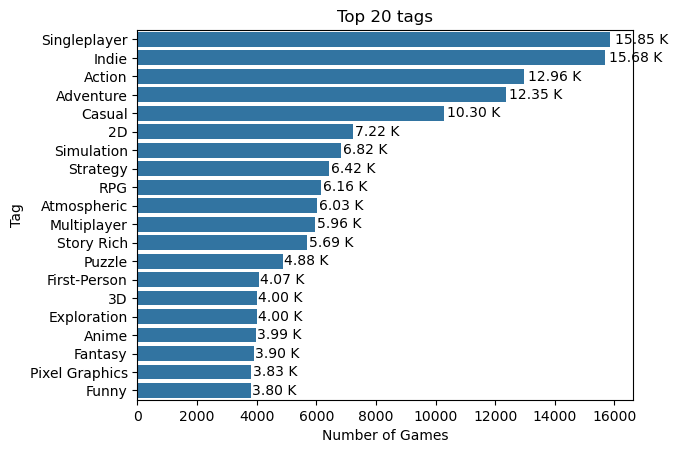

In [27]:
viz_tags = df_exploded_tags.groupBy('game_detail_tags').count()
viz_tags = viz_tags.orderBy('count', ascending=False)
viz_tags = viz_tags.toPandas()

# Bar chart
sns.barplot(x='count', y='game_detail_tags', data=viz_tags.head(20))
plt.title('Top 20 tags')
plt.xlabel('Number of Games')
plt.ylabel('Tag')

# Get current Axes
ax = plt.gca()

# Add text labels formatted as millions
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    if width < 1_000:
        label = f'{width:.2f}'
    else:
        label = f'{width/1_000:.2f} K'
    ax.text(width + (width * 0.01), y, label, va='center')

plt.show()

## Term Frequency–Inverse Document Frequency vectors (TF-IDF)

In [28]:
df_genres = df_exploded_genres.withColumn(
    'game_detail_genres',
    concat(lit('genre_'), df_exploded_genres['game_detail_genres'])
).withColumnRenamed('game_detail_genres', 'feature')

df_tags = df_exploded_tags.withColumn(
    'game_detail_tags',
    concat(lit('tag_'), df_exploded_tags['game_detail_tags'])
).withColumnRenamed('game_detail_tags', 'feature')

In [29]:
df_multi_hot = df_genres.union(df_tags)

In [30]:
# df_multi_hot = df_multi_hot.withColumn('value',lit(1))
# df_multi_hot = df_multi_hot.groupBy('game_appid').pivot('feature').sum('value').fillna(0)

In [31]:
# HashingTF → sparse vector for tags
hashing_tf= HashingTF(inputCol='feature', outputCol='rawFeatures', numFeatures=100)
tf= hashing_tf.transform(df_multi_hot.groupBy('game_appid').agg(collect_list('feature').alias('feature')))

In [32]:
tf.show(5)

+----------+--------------------+--------------------+
|game_appid|             feature|         rawFeatures|
+----------+--------------------+--------------------+
|        50|[genre_Action, ta...|(100,[0,10,19,24,...|
|       130|[genre_Action, ta...|(100,[0,10,19,28,...|
|       570|[genre_Action, ge...|(100,[5,19,22,24,...|
|       730|[genre_Action, ge...|(100,[5,19,22,24,...|
|      1002|[genre_Indie, tag...|(100,[1,9,19,29,3...|
+----------+--------------------+--------------------+
only showing top 5 rows


In [33]:
# IDF for weighting
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(tf)
tfidf = idf_model.transform(tf)

In [34]:
tfidf.show(5)

+----------+--------------------+--------------------+--------------------+
|game_appid|             feature|         rawFeatures|            features|
+----------+--------------------+--------------------+--------------------+
|        50|[genre_Action, ta...|(100,[0,10,19,24,...|(100,[0,10,19,24,...|
|       130|[genre_Action, ta...|(100,[0,10,19,28,...|(100,[0,10,19,28,...|
|       570|[genre_Action, ge...|(100,[5,19,22,24,...|(100,[5,19,22,24,...|
|       730|[genre_Action, ge...|(100,[5,19,22,24,...|(100,[5,19,22,24,...|
|      1002|[genre_Indie, tag...|(100,[1,9,19,29,3...|(100,[1,9,19,29,3...|
+----------+--------------------+--------------------+--------------------+
only showing top 5 rows


## Joining with original df wihtout nulls

In [35]:
df_clean = df_rating.drop('game_detail_genres', 'game_detail_tags')

### Replacing nulls

In [36]:
df_clean = df_clean.fillna({'user_loccountrycode': 'Unknown',
                            'game_detail_developer': 'Unkown',
                            'game_detail_publisher': 'Unknown'})

df_clean = df_clean.withColumn(
    "game_name",
    when(col("game_name").isNull(), concat(lit("Unknown_"), col("game_appid")))
    .otherwise(col("game_name"))
)

In [37]:
df_info(df_clean)

+------------------------+-------+-----+------+
|column_name             |filled |nulls|unique|
+------------------------+-------+-----+------+
|game_appid              |1579134|0    |27555 |
|user_personaname        |1579134|0    |12664 |
|user_loccountrycode     |1579134|0    |189   |
|game_detail_release_date|1579134|0    |5314  |
|raw_tile                |1579134|0    |5     |
|game_playtime_forever   |1579134|0    |49924 |
|game_detail_rating      |1579134|0    |18    |
|user_steamid            |1579134|0    |12870 |
|game_detail_developer   |1579134|0    |16169 |
|game_name               |1579134|0    |27523 |
|game_detail_publisher   |1579134|0    |11953 |
|rating                  |1579134|0    |5     |
+------------------------+-------+-----+------+



### Transforming string to data

In [38]:
df_clean = df_clean.withColumn('game_detail_release_date', to_date('game_detail_release_date', 'yyyy-MM-dd'))

In [39]:
df_clean.printSchema()

root
 |-- user_steamid: string (nullable = true)
 |-- user_personaname: string (nullable = true)
 |-- user_loccountrycode: string (nullable = false)
 |-- game_appid: long (nullable = true)
 |-- game_name: string (nullable = true)
 |-- game_playtime_forever: double (nullable = true)
 |-- game_detail_release_date: date (nullable = true)
 |-- game_detail_developer: string (nullable = false)
 |-- game_detail_publisher: string (nullable = false)
 |-- game_detail_rating: string (nullable = true)
 |-- raw_tile: integer (nullable = false)
 |-- rating: integer (nullable = false)



### Final join

In [40]:
df_joined = df_clean.join(
    tfidf,
    on='game_appid',
    how='left'
)

In [41]:
df_joined.show(5)

+----------+-----------------+----------------+-------------------+----------------+---------------------+------------------------+---------------------+---------------------+------------------+--------+------+--------------------+--------------------+--------------------+
|game_appid|     user_steamid|user_personaname|user_loccountrycode|       game_name|game_playtime_forever|game_detail_release_date|game_detail_developer|game_detail_publisher|game_detail_rating|raw_tile|rating|             feature|         rawFeatures|            features|
+----------+-----------------+----------------+-------------------+----------------+---------------------+------------------------+---------------------+---------------------+------------------+--------+------+--------------------+--------------------+--------------------+
|       570|76561197960446787|            Anna|                 BR|          Dota 2|               4018.0|              2013-07-09|                Valve|                Valve|   

In [42]:
df_joined.printSchema()

root
 |-- game_appid: long (nullable = true)
 |-- user_steamid: string (nullable = true)
 |-- user_personaname: string (nullable = true)
 |-- user_loccountrycode: string (nullable = false)
 |-- game_name: string (nullable = true)
 |-- game_playtime_forever: double (nullable = true)
 |-- game_detail_release_date: date (nullable = true)
 |-- game_detail_developer: string (nullable = false)
 |-- game_detail_publisher: string (nullable = false)
 |-- game_detail_rating: string (nullable = true)
 |-- raw_tile: integer (nullable = false)
 |-- rating: integer (nullable = false)
 |-- feature: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [43]:
df_joined_select = df_joined.select('user_steamid', 'game_appid')
df_info(df_joined_select)

+------------+-------+-----+------+
|column_name |filled |nulls|unique|
+------------+-------+-----+------+
|game_appid  |1579134|0    |27555 |
|user_steamid|1579134|0    |12870 |
+------------+-------+-----+------+



# Save results

In [44]:
now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S.%f')
df_joined.coalesce(1).write.parquet(f"db/{now}.parquet")

In [57]:
df_clean.filter(col("user_steamid") == '76561198170914390') \
    .orderBy(col("game_playtime_forever").desc()) \
    .show(100)

+------------+----------------+-------------------+----------+---------+---------------------+------------------------+---------------------+---------------------+------------------+--------+------+
|user_steamid|user_personaname|user_loccountrycode|game_appid|game_name|game_playtime_forever|game_detail_release_date|game_detail_developer|game_detail_publisher|game_detail_rating|raw_tile|rating|
+------------+----------------+-------------------+----------+---------+---------------------+------------------------+---------------------+---------------------+------------------+--------+------+
+------------+----------------+-------------------+----------+---------+---------------------+------------------------+---------------------+---------------------+------------------+--------+------+



In [56]:
df_joined.filter(col("user_personaname") == "Nuskuler") \
         .orderBy(col("game_playtime_forever").desc()) \
         .show(100)

+----------+------------+----------------+-------------------+---------+---------------------+------------------------+---------------------+---------------------+------------------+--------+------+-------+-----------+--------+
|game_appid|user_steamid|user_personaname|user_loccountrycode|game_name|game_playtime_forever|game_detail_release_date|game_detail_developer|game_detail_publisher|game_detail_rating|raw_tile|rating|feature|rawFeatures|features|
+----------+------------+----------------+-------------------+---------+---------------------+------------------------+---------------------+---------------------+------------------+--------+------+-------+-----------+--------+
+----------+------------+----------------+-------------------+---------+---------------------+------------------------+---------------------+---------------------+------------------+--------+------+-------+-----------+--------+



In [47]:
df_joined.filter(col("user_personaname") == "Nonakus") \
         .orderBy(col("game_playtime_forever").desc()) \
         .show(100)

+----------+-----------------+----------------+-------------------+--------------------+---------------------+------------------------+---------------------+---------------------+--------------------+--------+------+--------------------+--------------------+--------------------+
|game_appid|     user_steamid|user_personaname|user_loccountrycode|           game_name|game_playtime_forever|game_detail_release_date|game_detail_developer|game_detail_publisher|  game_detail_rating|raw_tile|rating|             feature|         rawFeatures|            features|
+----------+-----------------+----------------+-------------------+--------------------+---------------------+------------------------+---------------------+---------------------+--------------------+--------+------+--------------------+--------------------+--------------------+
|   3416070|76561198147702705|         Nonakus|                 MX|Ropuka's Idle Island|              10109.0|              2025-01-29| Moczan,Little Chm...|   